In [13]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.datasets import Planetoid
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [14]:
# 1.加载Cora数据集
dataset = Planetoid(root='./data/Citeseer', name='Citeseer') # Cora  ,  Citeseer ,  PubMed

In [15]:
# 2.定义GCNConv网络
class GCN(nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(num_node_features, 64)
        self.conv2 = pyg_nn.GCNConv(64, num_classes)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

【EPOCH: 】1
训练损失为：1.7930 训练精度为：0.2083
【EPOCH: 】21
训练损失为：1.4737 训练精度为：0.8667
【EPOCH: 】41
训练损失为：1.0815 训练精度为：0.9250
【EPOCH: 】61
训练损失为：0.7941 训练精度为：0.9417
【EPOCH: 】81
训练损失为：0.5409 训练精度为：0.9583
【EPOCH: 】101
训练损失为：0.3951 训练精度为：0.9833
【EPOCH: 】121
训练损失为：0.2841 训练精度为：0.9750
【EPOCH: 】141
训练损失为：0.2411 训练精度为：0.9917
【EPOCH: 】161
训练损失为：0.1841 训练精度为：0.9917
【EPOCH: 】181
训练损失为：0.1347 训练精度为：1.0000
【Finished Training！】
Train Accuracy: 1.0000 Train Loss: 0.1035
Test  Accuracy: 0.6750 Test  Loss: 1.0734
F1 Score: 0.6441


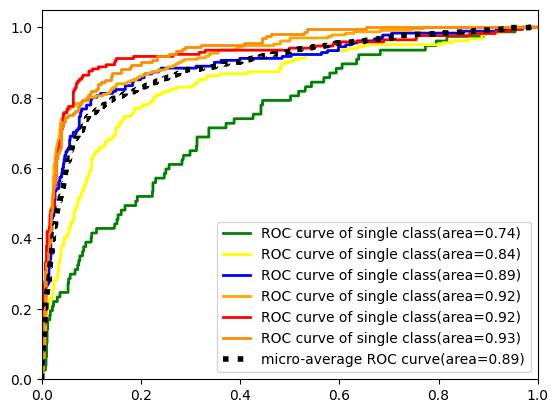

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 设备
epochs = 200 # 学习轮数
lr = 0.0003 # 学习率
num_node_features = dataset.num_node_features # 每个节点的特征数
num_classes = dataset.num_classes # 每个节点的类别数
data = dataset[0].to(device) # Cora的一张图

# 3.定义模型
model = GCN(num_node_features, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # 优化器
loss_function = nn.NLLLoss() # 损失函数

# 训练模式
model.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(data)
    
    loss = loss_function(pred[data.train_mask], data.y[data.train_mask]) # 损失
    correct_count_train = pred.argmax(axis=1)[data.train_mask].eq(data.y[data.train_mask]).sum().item() # epoch正确分类数目
    acc_train = correct_count_train / data.train_mask.sum().item() # epoch训练精度
    
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print("【EPOCH: 】%s" % str(epoch + 1))
        print('训练损失为：{:.4f}'.format(loss.item()), '训练精度为：{:.4f}'.format(acc_train))

print('【Finished Training！】')

# 模型验证
model.eval()
pred = model(data)

# 训练集（使用了掩码）
correct_count_train = pred.argmax(axis=1)[data.train_mask].eq(data.y[data.train_mask]).sum().item()
acc_train = correct_count_train / data.train_mask.sum().item()
loss_train = loss_function(pred[data.train_mask], data.y[data.train_mask]).item()

# 测试集
correct_count_test = pred.argmax(axis=1)[data.test_mask].eq(data.y[data.test_mask]).sum().item()
acc_test = correct_count_test / data.test_mask.sum().item()
loss_test = loss_function(pred[data.test_mask], data.y[data.test_mask]).item()

print('Train Accuracy: {:.4f}'.format(acc_train), 'Train Loss: {:.4f}'.format(loss_train))
print('Test  Accuracy: {:.4f}'.format(acc_test), 'Test  Loss: {:.4f}'.format(loss_test))
# 计算F1值

f1 = f1_score(data.y[data.test_mask].cpu(), pred.argmax(axis=1)[data.test_mask].cpu(), average='macro')
print('F1 Score: {:.4f}'.format(f1))
y_test = label_binarize(data.y[data.test_mask],classes=[0,1,2,3,4,5])
pred = pred.detach()
y_score = pred[data.test_mask]
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i],tpr[i],_ = roc_curve(y_test[:,i],y_score[:,i])
    roc_auc[i] = auc(fpr[i],tpr[i])

fpr['micro'],tpr['micro'],_ = roc_curve(y_test.ravel(),y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'],tpr['micro'])
plt.figure()
lw=2
color = ['green','yellow','blue','orange','red','darkorange','navy']
for i in range(6): #7 #6 #3
    plt.plot(fpr[i],tpr[i],color=color[i],lw=lw,label='ROC curve of single class(area=%0.2f)'%roc_auc[i])

plt.plot(fpr['micro'],tpr['micro'],label='micro-average ROC curve(area={0:0.2f})'.format(roc_auc['micro']),color='black',linestyle=':',linewidth=4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='lower right')
plt.show()

